# Homework 6 (appendix)
### Author: Mateusz Sieniawski

In [1]:
import shap
import random
import pickle

import pandas as pd
import numpy as np
import seaborn as sns
import xgboost as xgb
import lightgbm as lgb

from pdpbox import pdp, get_dataset, info_plots
from sklearn.inspection import plot_partial_dependence
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_log_error as msle
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import mean_squared_error as mse
import matplotlib.pyplot as plt
from collections.abc import Iterable
from sklearn.metrics import accuracy_score

np.random.seed(42)
random.seed(42)

In [2]:
df = pd.read_csv("titanic.csv")
df = df.drop(['Name'], axis=1)
df = pd.get_dummies(df)

target_col = "Survived"
X = df.drop([target_col], axis=1)
Y = df[[target_col]]

In [3]:
# split data into train and test sets
seed = 42
test_size = 0.5
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=test_size, random_state=seed)

In [4]:
# https://stackoverflow.com/questions/31324218/scikit-learn-how-to-obtain-true-positive-true-negative-false-positive-and-fal
def perf_measure(y_actual, y_hat):
    TP = 0
    FP = 0
    TN = 0
    FN = 0

    for i in range(len(y_hat)): 
        if y_actual[i]==y_hat[i]==1:
           TP += 1
        if y_hat[i]==1 and y_actual[i]!=y_hat[i]:
           FP += 1
        if y_actual[i]==y_hat[i]==0:
           TN += 1
        if y_hat[i]==0 and y_actual[i]!=y_hat[i]:
           FN += 1

    return(TP, FP, TN, FN)

In [5]:
def get_statistics(y_actual, y_hat):
    (TP, FP, TN, FN) = perf_measure(y_actual, y_hat)
    accuracy_equality_ratio = (TP + TN) / (TP + FP + TN + FN)
    equal_opportunity_ratio = TP/(TP + FN)
    predictive_equality_ratio = FP / (FP + TN)
    predictive_parity_ratio = TP / (TP + FP)
    statistical_parity_ratio = (TP +FP)/(TP + FP + TN + FN)
    return accuracy_equality_ratio, equal_opportunity_ratio, predictive_equality_ratio, predictive_parity_ratio, statistical_parity_ratio

In [6]:
X_test_female = X_test[X_test['Sex_female'] == 1]
y_test_female = y_test[X_test['Sex_female'] == 1]
X_test_male = X_test[X_test['Sex_female'] == 0]
y_test_male = y_test[X_test['Sex_female'] == 0]
print(len(X_test_male))
print(len(X_test_female))

294
150


In [7]:
columns = ['model', "sex", 'accuracy_equality_ratio', 'equal_opportunity_ratio', 'predictive_equality_ratio', 'predictive_parity_ratio', 'statistical_parity_ratio']
plot_data = pd.DataFrame(columns=columns)

### XGBoost

In [8]:
model = xgb.XGBClassifier()
model.fit(X_train, y_train)
print(model)

y_pred = model.predict(X_test)
xgboost_accuracy = accuracy_score(y_test, y_pred)
print(f"XGBoost accuracy: {xgboost_accuracy*100:.1f}%")

[21:34:11] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=8, num_parallel_tree=1,
              objective='binary:logistic', random_state=0, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', use_label_encoder=True,
              validate_parameters=1, verbosity=None)
XGBoost accuracy: 78.4%


In [9]:
y_pred_female = model.predict(X_test_female)
y_pred_male = model.predict(X_test_male)
(f1, f2, f3, f4, f5) = get_statistics(y_test_female.to_numpy(), y_pred_female)
(m1, m2, m3, m4, m5) = get_statistics(y_test_male.to_numpy(), y_pred_male)
(t1, t2, t3, t4, t5) = get_statistics(y_test.to_numpy(), y_pred)
#print(f1, f2, f3, f4, f5)
#print(m1, m2, m3, m4, m5)
print(t1, t2, t3, t4, t5)
#print(f1/t1, f2/t2, f3/t3, f4/t4, f5/t5)
plot_data = plot_data.append(pd.DataFrame([['XGBoost', "female", min(f1/m1, f1/f1), min(f2/m2, f2/f2), min(f3/m3, f3/f3), min(f4/m4, f4/f4), min(f5/m5, f5/f5)]], columns=columns))
plot_data = plot_data.append(pd.DataFrame([['XGBoost', "male", min(m1/m1, m1/f1), min(m2/m2, m2/f2), min(m3/m3, m3/f3), min(m4/m4, m4/f4), min(m5/m5, m5/f5)]], columns=columns))

0.7837837837837838 0.6460674157303371 0.12406015037593984 0.777027027027027 0.3333333333333333


### Logistic regression

In [10]:
reg = LogisticRegression().fit(X_train, y_train)
print(reg)

y_pred = reg.predict(X_test)
reg_accuracy = accuracy_score(y_test, y_pred)
print(f"Logistic regression accuracy: {reg_accuracy*100:.1f}%")

"""
for (coef, col) in zip(reg.coef_[0], X_train.columns):
    print(f"{col} - {coef}")



plt.figure(figsize = (20,14))
sns.barplot(X_train.columns, reg.coef_[0])
#g.set(ylim=(0.9, 1.25))

plt.title("Linear regression coefficients", fontsize=20)
plt.xlabel("variable", fontsize=20)
plt.ylabel("coefficient", fontsize=20)
plt.xticks(fontsize=14, rotation=45)
plt.yticks(fontsize=14)

#plt.show()
#plt.savefig("img/reg_coef.png")
""" 

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)
Logistic regression accuracy: 79.3%


'\nfor (coef, col) in zip(reg.coef_[0], X_train.columns):\n    print(f"{col} - {coef}")\n\n\n\nplt.figure(figsize = (20,14))\nsns.barplot(X_train.columns, reg.coef_[0])\n#g.set(ylim=(0.9, 1.25))\n\nplt.title("Linear regression coefficients", fontsize=20)\nplt.xlabel("variable", fontsize=20)\nplt.ylabel("coefficient", fontsize=20)\nplt.xticks(fontsize=14, rotation=45)\nplt.yticks(fontsize=14)\n\n#plt.show()\n#plt.savefig("img/reg_coef.png")\n'

In [11]:
y_pred_female = reg.predict(X_test_female)
y_pred_male = reg.predict(X_test_male)
(f1, f2, f3, f4, f5) = get_statistics(y_test_female.to_numpy(), y_pred_female)
(m1, m2, m3, m4, m5) = get_statistics(y_test_male.to_numpy(), y_pred_male)
(t1, t2, t3, t4, t5) = get_statistics(y_test.to_numpy(), y_pred)
#print(f1, f2, f3, f4, f5)
#print(m1, m2, m3, m4, m5)
print(t1, t2, t3, t4, t5)
#print(f1/t1, f2/t2, f3/t3, f4/t4, f5/t5)
plot_data = plot_data.append(pd.DataFrame([['Logistic regression', "female", min(f1/m1, f1/f1), min(f2/m2, f2/f2), min(f3/m3, f3/f3), min(f4/m4, f4/f4), min(f5/m5, f5/f5)]], columns=columns))
plot_data = plot_data.append(pd.DataFrame([['Logistic regression', "male", min(m1/m1, m1/f1), min(m2/m2, m2/f2), min(m3/m3, m3/f3), min(m4/m4, m4/f4), min(m5/m5, m5/f5)]], columns=columns))

0.7927927927927928 0.6348314606741573 0.10150375939849623 0.8071428571428572 0.3153153153153153
1.0259090909090909 1.4637011512256246 5.325325325325326 1.0407079646017698 2.642857142857143


### Random forest

In [12]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier()
rf.fit(X_train, y_train)
print(rf)

y_pred = rf.predict(X_test)
rf_accuracy = accuracy_score(y_test, y_pred)
print(f"Random forest accuracy: {rf_accuracy*100:.1f}%")

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)
Random forest accuracy: 78.6%


In [13]:
y_pred_female = rf.predict(X_test_female)
y_pred_male = rf.predict(X_test_male)
(f1, f2, f3, f4, f5) = get_statistics(y_test_female.to_numpy(), y_pred_female)
(m1, m2, m3, m4, m5) = get_statistics(y_test_male.to_numpy(), y_pred_male)
(t1, t2, t3, t4, t5) = get_statistics(y_test.to_numpy(), y_pred)
#print(f1, f2, f3, f4, f5)
#print(m1, m2, m3, m4, m5)
print(t1, t2, t3, t4, t5)
print(f1/t1, f2/t2, f3/t3, f4/t4, f5/t5)
plot_data = plot_data.append(pd.DataFrame([['Random forest', "female", min(f1/m1, f1/f1), min(f2/m2, f2/f2), min(f3/m3, f3/f3), min(f4/m4, f4/f4), min(f5/m5, f5/f5)]], columns=columns))
plot_data = plot_data.append(pd.DataFrame([['Random forest', "male", min(m1/m1, m1/f1), min(m2/m2, m2/f2), min(m3/m3, m3/f3), min(m4/m4, m4/f4), min(m5/m5, m5/f5)]], columns=columns))

0.786036036036036 0.6292134831460674 0.10902255639097744 0.7943262411347518 0.31756756756756754
0.9244699140401147 1.265802781289507 4.4622553588070835 1.0491071428571428 2.2672340425531914


### KNN

In [14]:
from sklearn.neighbors import KNeighborsClassifier

knn = KNeighborsClassifier()
knn.fit(X_train, y_train)
print(knn)

y_pred = knn.predict(X_test)
knn_accuracy = accuracy_score(y_test, y_pred)
print(f"KNN accuracy: {knn_accuracy*100:.1f}%")

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=5, p=2,
                     weights='uniform')
KNN accuracy: 70.0%


In [15]:
y_pred_female = knn.predict(X_test_female)
y_pred_male = knn.predict(X_test_male)
(f1, f2, f3, f4, f5) = get_statistics(y_test_female.to_numpy(), y_pred_female)
(m1, m2, m3, m4, m5) = get_statistics(y_test_male.to_numpy(), y_pred_male)
(t1, t2, t3, t4, t5) = get_statistics(y_test.to_numpy(), y_pred)
#print(f1, f2, f3, f4, f5)
#print(m1, m2, m3, m4, m5)
print(t1, t2, t3, t4, t5)
print(f1/t1, f2/t2, f3/t3, f4/t4, f5/t5)
plot_data = plot_data.append(pd.DataFrame([['KNN', "female", min(f1/m1, f1/f1), min(f2/m2, f2/f2), min(f3/m3, f3/f3), min(f4/m4, f4/f4), min(f5/m5, f5/f5)]], columns=columns))
plot_data = plot_data.append(pd.DataFrame([['KNN', "male", min(m1/m1, m1/f1), min(m2/m2, m2/f2), min(m3/m3, m3/f3), min(m4/m4, m4/f4), min(m5/m5, m5/f5)]], columns=columns))

0.7004504504504504 0.5786516853932584 0.21804511278195488 0.639751552795031 0.36261261261261263
0.8470739549839229 1.0093650657272963 1.735321528424977 1.2895631067961164 1.470807453416149


In [16]:
plot_data

,model,sex,accuracy_equality_ratio,equal_opportunity_ratio,predictive_equality_ratio,predictive_parity_ratio,statistical_parity_ratio
0,XGBoost,female,0.930169,1.000000,1.000000,1.000000,1.000000
0,XGBoost,male,1.000000,0.533392,0.248572,0.659333,0.237422
0,Logistic regression,female,1.000000,1.000000,1.000000,1.000000,1.000000
0,Logistic regression,male,0.961860,0.132454,0.056550,0.634921,0.061224
0,Random forest,female,0.890167,1.000000,1.000000,1.000000,1.000000
0,Random forest,male,1.000000,0.424957,0.098738,0.800000,0.155896
0,KNN,female,0.785766,1.000000,1.000000,1.000000,1.000000
0,KNN,male,1.000000,0.974592,0.507798,0.553685,0.516582


<Figure size 1008x1440 with 0 Axes>

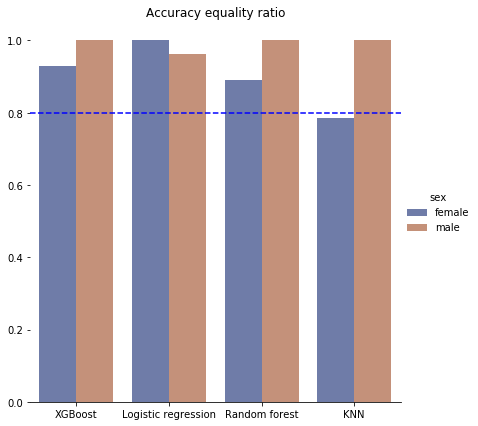

In [17]:
plt.figure(figsize = (14,20))

g = sns.catplot(
    data=plot_data, kind="bar", hue="sex",
    x="model", y='accuracy_equality_ratio',
    ci="sd", palette="dark", alpha=.6, height=6
)
g.despine(left=True)
g.set_axis_labels("", "")

plt.axhline(y=0.8, color='b', linestyle='--')

plt.title("Accuracy equality ratio")
plt.savefig("img/accuracy_equality_ratio.png", bbox_inches='tight')

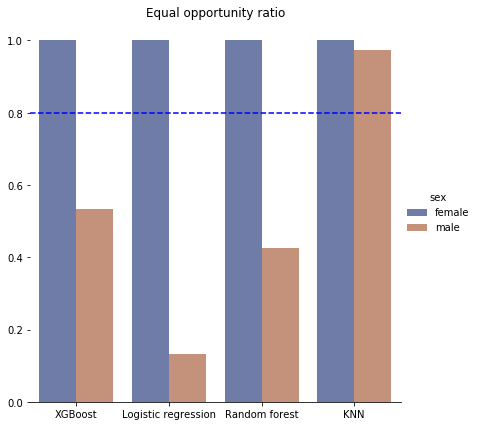

In [18]:
g = sns.catplot(
    data=plot_data, kind="bar", hue="sex",
    x="model", y='equal_opportunity_ratio',
    ci="sd", palette="dark", alpha=.6, height=6
)
g.despine(left=True)
g.set_axis_labels("", "")

plt.axhline(y=0.8, color='b', linestyle='--')

plt.title("Equal opportunity ratio")
plt.savefig("img/equal_opportunity_ratio.png", bbox_inches='tight')

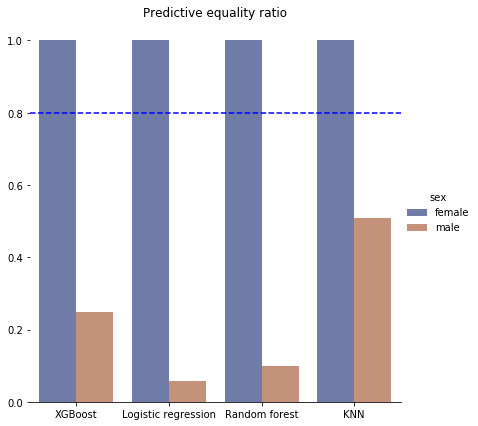

In [19]:
g = sns.catplot(
    data=plot_data, kind="bar", hue="sex",
    x="model", y='predictive_equality_ratio',
    ci="sd", palette="dark", alpha=.6, height=6
)
g.despine(left=True)
g.set_axis_labels("", "")

plt.axhline(y=0.8, color='b', linestyle='--')

plt.title("Predictive equality ratio")
plt.savefig("img/predictive_equality_ratio.png", bbox_inches='tight')

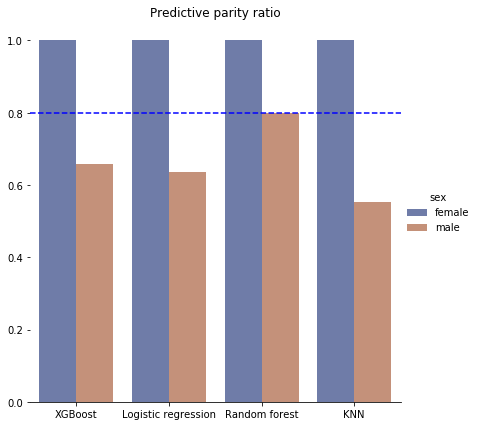

In [20]:
g = sns.catplot(
    data=plot_data, kind="bar", hue="sex",
    x="model", y='predictive_parity_ratio',
    ci="sd", palette="dark", alpha=.6, height=6
)
g.despine(left=True)
g.set_axis_labels("", "")

plt.axhline(y=0.8, color='b', linestyle='--')

plt.title("Predictive parity ratio")
plt.savefig("img/predictive_parity_ratio.png", bbox_inches='tight')

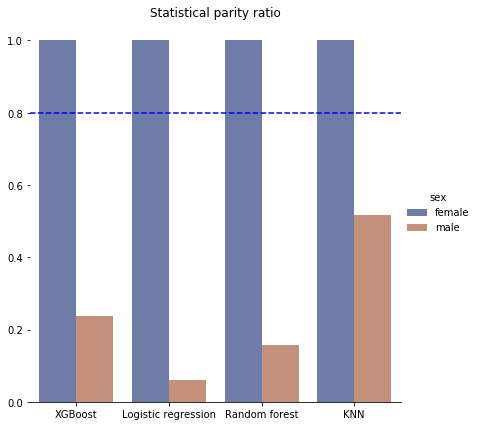

In [21]:
g = sns.catplot(
    data=plot_data, kind="bar", hue="sex",
    x="model", y='statistical_parity_ratio',
    ci="sd", palette="dark", alpha=.6, height=6
)
g.despine(left=True)
g.set_axis_labels("", "")

plt.axhline(y=0.8, color='b', linestyle='--')

plt.title("Statistical parity ratio")
plt.savefig("img/statistical_parity_ratio.png", bbox_inches='tight')